In [1]:
import sys
sys.path.append('..')  # this adds the parent directory to the sys.path
import warnings
warnings.filterwarnings('ignore')


In [2]:
from data_science_funcs import *
import pandas as pd
import vectorbtpro as vbt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.utils import class_weight


In [3]:
pickle_files_path = "../data/RID0029_LSTM_pw38_lb250_bt2000_mem6000/*.pkl"
# pickle_files_path = "../data/RID0028_LSTM_pw75_lb250_bt2000_mem5000"
prediction_window = 38
filename_prefix = pickle_files_path.split('/')[-2]
min_num_entries          = 100
excel_output_file_name  = f"../results/{filename_prefix + '.xlsx'}"
lstm_output_file_name   = f"../results/{filename_prefix + 'lstm_model_outputs.csv'}"
lstm_results_file_name  = f"../results/{filename_prefix + 'lstm_model_results.csv'}"

In [4]:
df = pd.read_csv(lstm_output_file_name, index_col=0, parse_dates=True, infer_datetime_format=True)
# df.to_csv(lstm_output_file_name)

In [5]:
# Define mapping from old names to new ones
column_mapping = {
    'BTCUSDT_Open': 'Open',
    'BTCUSDT_High': 'High',
    'BTCUSDT_Low': 'Low',
    'BTCUSDT_Close': 'Close',
    'long_minus_short': 'long_minus_short',
    'long_slope': 'long_slope',
    'short_slope': 'short_slope'
}

# Rename columns using the mapping
df = df.rename(columns=column_mapping)


In [7]:
df.Close.resample('1h').agg('last').vbt.plot().show()

In [6]:
def prepare_meta_data(data, atr_multiplier=1, prediction_window=75):
    """
    Prepare data for the meta-model. 
    Adds the triple barrier labels and selects the relevant features.
    """
    # Apply triple barrier to get labels
    data_labeled = apply_triple_barrier(data, atr_multiplier, prediction_window, use_four_labels=False)
    
    # Select relevant columns as features
    # X = data_labeled[['long_minus_short', 'long_slope', 'short_slope', 'Close']]
    X = data_labeled[['Open', 'High', 'Low', 'Close']]
    
    
    # Target variable
    y = data_labeled['label']
    
    return X, y

In [16]:
X, y = prepare_meta_data(df, atr_multiplier=5, prediction_window=prediction_window)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Create a pipeline for the XGBoost classification model
pipeline = create_pipeline(X_train, model='xgb', task='classification')
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.39      0.32      0.36      4133
           1       0.43      0.56      0.49      4871
           2       0.42      0.35      0.38      4237

    accuracy                           0.42     13241
   macro avg       0.41      0.41      0.41     13241
weighted avg       0.42      0.42      0.41     13241



In [19]:
# Your existing data preparation step
X, y = prepare_meta_data(df, atr_multiplier=5, prediction_window=prediction_window)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights = {i: class_weights[i] for i in range(len(class_weights))}

# Generate sample weights based on y_train's classes
y_train_series = pd.Series(y_train)
sample_weights = y_train_series.map(weights)

# Modify pipeline (omitting the class_weight parameter)
pipeline = create_pipeline(X_train, model='xgb', task='classification')
pipeline.fit(X_train, y_train, model__sample_weight=sample_weights)
y_pred = pipeline.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.39      0.43      0.41      4133
           1       0.44      0.42      0.43      4871
           2       0.42      0.40      0.41      4237

    accuracy                           0.42     13241
   macro avg       0.42      0.42      0.42     13241
weighted avg       0.42      0.42      0.42     13241



In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define XGBoost classifier
clf = xgb.XGBClassifier(objective='multi:softmax', num_class=len(set(y)))

# Hyperparameters grid
param_grid = {
    'learning_rate': [0.05, 0.25],
    'n_estimators': [100, 400],
    'max_depth': [1, 4, 6],
    'subsample': [0.5, 0.9],
    'colsample_bytree': [0.6, 1]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(clf, param_grid, scoring='accuracy', cv=3, verbose=1)

# Using GridSearchCV to find the best hyperparameters
grid_search.fit(X_train_new, y_train_new, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=10)

# Predict on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

# Displaying the classification report
print("Best Parameters: ", grid_search.best_params_)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


In [34]:

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

clf = xgb.XGBClassifier(objective='multi:softmax', num_class=len(set(y)))

# Define a wider range for hyperparameters for Random Search
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
    'n_estimators': [50, 100, 200, 300, 400, 500, 600, 700, 800],
    'max_depth': [3, 4, 5, 6, 7, 8, 10, 12, 15],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2],
}

random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=200, scoring='accuracy', cv=3, verbose=10)
random_search.fit(X_train_resampled, y_train_resampled)

# Evaluation on the test set
y_pred = random_search.best_estimator_.predict(X_test)
print("Best Parameters: ", random_search.best_params_)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Fitting 3 folds for each of 200 candidates, totalling 600 fits
[CV 1/3; 1/200] START colsample_bytree=1.2, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.7
[CV 1/3; 1/200] END colsample_bytree=1.2, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.7;, score=nan total time=   0.0s
[CV 2/3; 1/200] START colsample_bytree=1.2, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.7
[CV 2/3; 1/200] END colsample_bytree=1.2, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.7;, score=nan total time=   0.0s
[CV 3/3; 1/200] START colsample_bytree=1.2, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.7
[CV 3/3; 1/200] END colsample_bytree=1.2, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.7;, score=nan total time=   0.0s
[CV 1/3; 2/200] START colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=0.6
[CV 1/3; 2/200] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, 

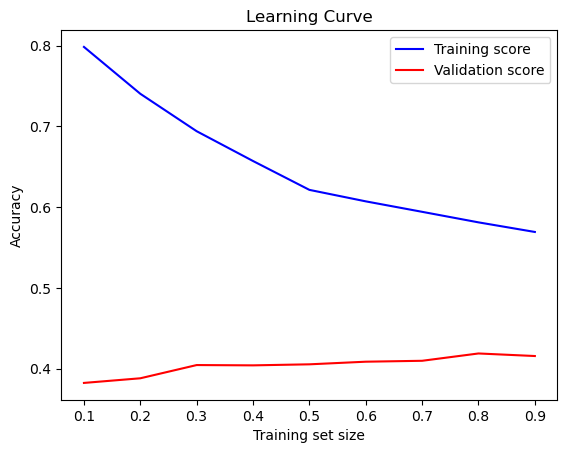

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Create a function for plotting the learning curve
def plot_learning_curve(X_train, y_train, clf):
    train_sizes = np.linspace(0.1, 1, 10) # or any number of points you want
    train_scores = []
    val_scores = []

    for train_size in train_sizes:
        if train_size == 1.0:  # Skip this iteration
            continue
        
        X_train_frac, _, y_train_frac, _ = train_test_split(
            X_train, y_train, train_size=train_size, random_state=42
        )
        
        clf.fit(X_train_frac, y_train_frac)
        
        train_score = clf.score(X_train_frac, y_train_frac)
        val_score = clf.score(X_val, y_val)

        train_scores.append(train_score)
        val_scores.append(val_score)

    plt.plot(train_sizes[:-1], train_scores, label="Training score", color="blue")  # Exclude the last point (1.0)
    plt.plot(train_sizes[:-1], val_scores, label="Validation score", color="red")
    plt.xlabel("Training set size")
    plt.ylabel("Accuracy")
    plt.title("Learning Curve")
    plt.legend()
    plt.show()


# Split your data to have a separate validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Assuming you've already defined your model and hyperparameters as `clf`
plot_learning_curve(X_train, y_train, clf)
